# Deep Learning Toolkit for Splunk - SVM with GridSearch Notebook

This notebook contains an example workflow how to work on an SVM model that receives a range of parameters to test using GridSearch to find the optimum SVM model using the Deep Learning Toolkit for Splunk.

Note: By default every time you save this notebook the cells are exported into a python module which is then invoked by Splunk MLTK commands like <code> | fit ... | apply ... | summary </code>. Please read the Model Development Guide in the Deep Learning Toolkit app for more information.

## Stage 0 - import libraries
At stage 0 we define all imports necessary to run our subsequent code depending on various libraries.

In [78]:
# this definition exposes all python module imports that should be available in all subsequent commands
import json
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import re
import joblib
from sklearn.model_selection import train_test_split
# ...
# global constants
MODEL_DIRECTORY = "/srv/app/model/data/"

In [79]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print("numpy version: " + np.__version__)
print("pandas version: " + pd.__version__)

numpy version: 1.18.1
pandas version: 1.0.1


## Stage 1 - get a data sample from Splunk
In Splunk run a search to pipe a dataset into your notebook environment. Note: mode=stage is used in the | fit command to do this. This example uses the housing.csv data loaded with the MLTK.

The GridSearch utilizes a range of parameters for the model, and tests all possible combinations of those parameters to find the set that provides the best results. In your Splunk search, you define your set of parameters to test your SVM model with by using the <b>grid</b> keyword. Wrap the full grid in double-quotes, and individual parameter test sets in curly-brackets.  In the example below, the linear kernel will be tested with C values of 10, 300 and 1000; and the rbf kernel will be tested with C values of 1, 10, and 1000, and gamma values of .01, 1, and 3.

| inputlookup housing.csv<br/>
| fit MLTKContainer mode=stage algo=grid_search_svm grid="{'kernel': ['linear'], 'C': [10., 300., 1000.]},{'kernel': ['rbf'], 'C': [1.0, 10., 1000.0],'gamma': [0.01, 1.0, 3.0]}," median_house_value from avg_rooms_per_dwelling, business_acres, charles_river_adjacency, crime_rate, distance_to_employment_center, highway_accessibility_index, land_zone, nitric_oxide_concentration, property_tax_rate, pupil_teacher_ratio, units_prior_1940 into app:svm_model

After you run this search your data set sample is available as a csv inside the container to develop your model. The name is taken from the into keyword ("svm_model" in the example above) or set to "default" if no into keyword is present. This step is intended to work with a subset of your data to create your custom model.

In [80]:
# this cell is not executed from MLTK and should only be used for staging data into the notebook environment
def stage(name):
    with open("data/"+name+".csv", 'r') as f:
        df = pd.read_csv(f)
    with open("data/"+name+".json", 'r') as f:
        param = json.load(f)
    return df, param

In [81]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
df, param = stage("svm_model")
print(param)

{'options': {'params': {'mode': 'stage', 'algo': 'svm', 'grid': '"{\'kernel\': [\'linear\'], \'C\': [10., 300., 1000.]},{\'kernel\': [\'rbf\'], \'C\': [1.0, 10., 1000.0],\'gamma\': [0.01, 1.0, 3.0]},"'}, 'args': ['median_house_value', 'avg_rooms_per_dwelling', 'business_acres', 'charles_river_adjacency', 'crime_rate', 'distance_to_employment_center', 'highway_accessibility_index', 'land_zone', 'nitric_oxide_concentration', 'property_tax_rate', 'pupil_teacher_ratio', 'units_prior_1940'], 'target_variable': ['median_house_value'], 'feature_variables': ['avg_rooms_per_dwelling', 'business_acres', 'charles_river_adjacency', 'crime_rate', 'distance_to_employment_center', 'highway_accessibility_index', 'land_zone', 'nitric_oxide_concentration', 'property_tax_rate', 'pupil_teacher_ratio', 'units_prior_1940'], 'model_name': 'svm_model', 'algo_name': 'MLTKContainer', 'mlspl_limits': {'handle_new_cat': 'default', 'max_distinct_cat_values': '100', 'max_distinct_cat_values_for_classifiers': '100',

In [82]:
df.describe()

,median_house_value,crime_rate,land_zone,business_acres,charles_river_adjacency,nitric_oxide_concentration,avg_rooms_per_dwelling,units_prior_1940,distance_to_employment_center,highway_accessibility_index,property_tax_rate,pupil_teacher_ratio
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534
std,9.197104,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000
75%,25.000000,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000


***
Once you have your data loaded, you can do some exploratory data analysis directly in the notebook.  See the plots below visualizing the variables in this data set. These images can be saved and included inside of Splunk dashboards as well.
***

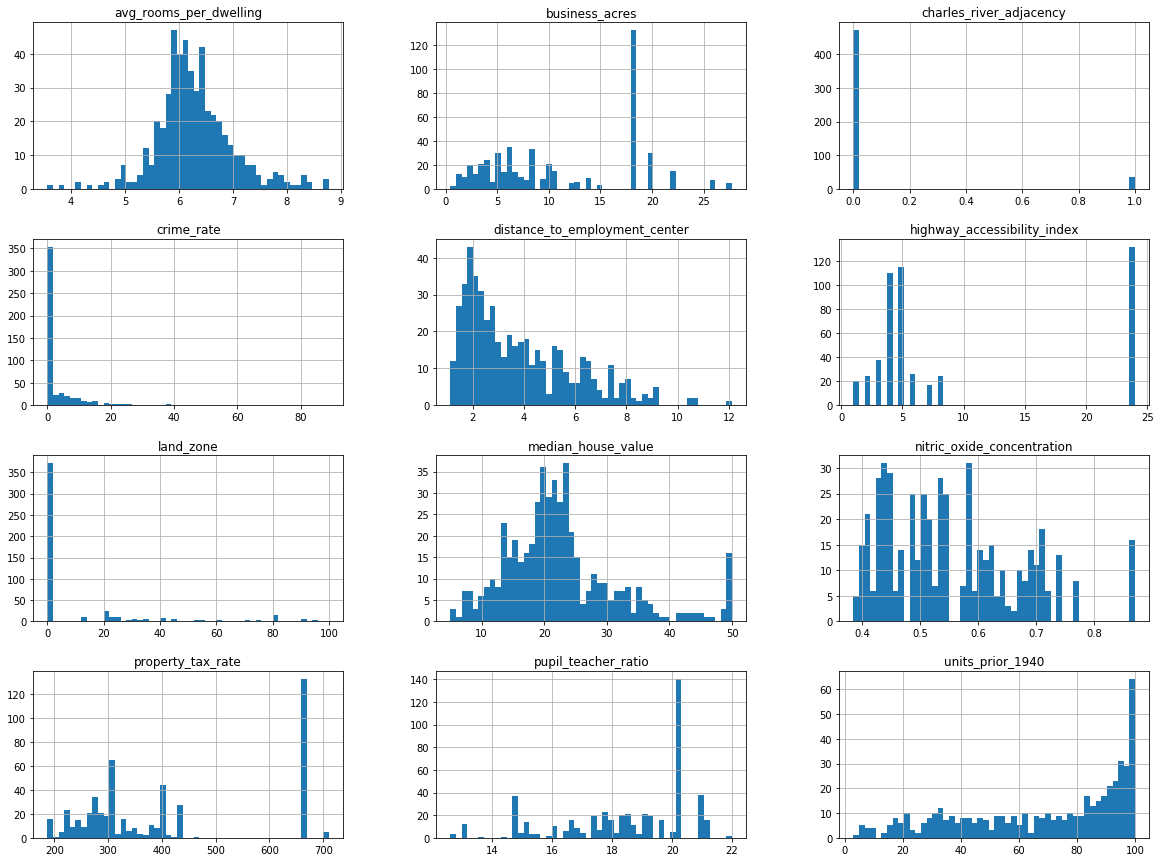

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [84]:
corr_matrix = df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value               1.000000
avg_rooms_per_dwelling           0.695360
land_zone                        0.360445
distance_to_employment_center    0.249929
charles_river_adjacency          0.175260
units_prior_1940                -0.376955
highway_accessibility_index     -0.381626
crime_rate                      -0.388305
nitric_oxide_concentration      -0.427321
property_tax_rate               -0.468536
business_acres                  -0.483725
pupil_teacher_ratio             -0.507787
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0cd4965d0>,
      dtype=object)

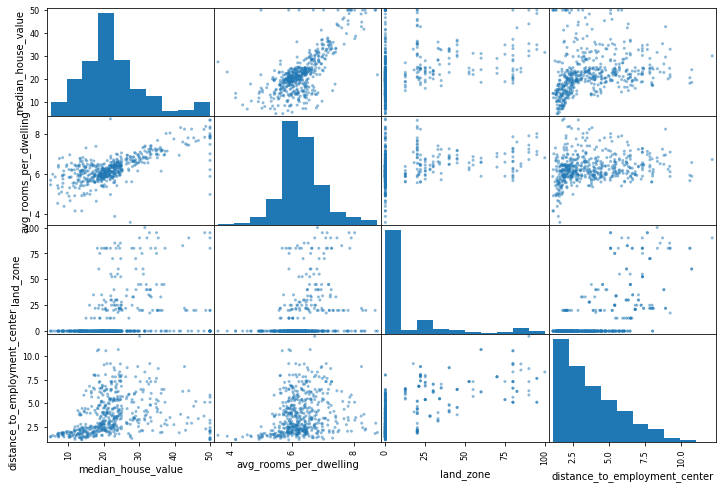

In [85]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "avg_rooms_per_dwelling", "land_zone",
              "distance_to_employment_center"]
scatter_matrix(df[attributes], figsize=(12, 8))

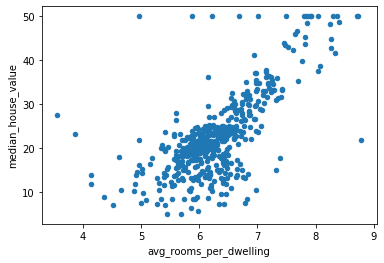

In [86]:
df.plot(kind="scatter", x="avg_rooms_per_dwelling", y="median_house_value")

## Stage 2 - create and initialize a model

In [87]:
def split_dataframe(df,param):
    # separate target variable and feature variables
    df_labels = np.ravel(df[param['options']['target_variable']])
    df_features = df[param['options']['feature_variables']]
    return df_labels,df_features

def run_grid_search(df, param):
    df_labels,df_features = split_dataframe(df,param)
    #get GridSearch parameters from Splunk search
    my_grid = param['options']['params']['grid']
    my_grid = my_grid.strip('\"')
    res = re.findall(r'\{.*?\}', my_grid)
    array_res = np.array(res)
    param_grid=[]
    for x in res:
        param_grid.append(eval(x))

    #define model
    model = SVR()

    # Perform gridsearch of model with parameters that have been passed to identify the best performing model parameters.
    #
    # Note: a gridsearch can be very compute intensive. The job below has n_jobs set to -1 which utilizes all of the 
    # available cores to process the search in parallel. Remove that parameter to process single-threaded (this will 
    # significantly increase processing time), or change to another value to specify how many processes can run in parallel.

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    grid_search.fit(df_features, df_labels)
    model = grid_search.best_estimator_
    return model

# initialize final model
# returns the model object which will be used as a reference to call fit, apply and summary subsequently

def init(df,param):
    model=run_grid_search(df,param)
    return model


In [88]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes

model=init(df,param)
print(model)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.5min finished


SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


## Stage 3 - fit the model

In [89]:
# train your model
# returns a fit info json object and may modify the model object
def fit(model,df,param):
    df_labels,df_features = split_dataframe(df,param)
    model.fit(df_features, df_labels)
    info = {"message": "model trained"}
    return info

In [90]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print(fit(model,df,param))

{'message': 'model trained'}


## Stage 4 - apply the model

In [91]:
# apply your model
# returns the calculated results
def apply(model,df,param):
    X = df[param['feature_variables']]
    y_hat = model.predict(X)
    result = pd.DataFrame(y_hat)
    return result

In [92]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print(apply(model,df,param))

             0
0     0.978313
1    21.739175
2    30.665977
3    29.203668
4    12.654771
..         ...
501  17.013751
502  15.229628
503  32.668137
504  16.797954
505  23.730751

[506 rows x 1 columns]


## Stage 5 - save the model

In [101]:
# save model to name in expected convention "<algo_name>_<model_name>"
def save(model,name):
    file = MODEL_DIRECTORY + name + ".pkl"
    joblib.dump(model, file) 
    return model

## Stage 6 - load the model

In [102]:
name="svm_model"
save(model,name)

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [103]:
# load model from name in expected convention "<algo_name>_<model_name>"
def load(name):
    file = MODEL_DIRECTORY + name + ".pkl"
    model = joblib.load(file)
    return model

## Stage 7 - provide a summary of the model

In [95]:
# return a model summary
def summary(model=None):
    returns = {"version": {"numpy": np.__version__, "pandas": pd.__version__} }
    return returns

## End of Stages
All subsequent cells are not tagged and can be used for further freeform code